## Time-Domain Analysis of Linear single-Track Vehicle

In [1]:
import sympy as sm
import sympy.physics.mechanics as me
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import solve_ivp

me.init_vprinting(use_latex = 'mathjax')

The single-track vehicle model schematic is on the main page of the repository.


In this analysis, the following assumptions are made [Pacejka, 2012]:

- The steering, side slip, and tire slip angles are assumed very small
- Roll angle and its derivative are set to zero
- Forward speed $u $ is considered constant and due to small angles, $u\approx V$
- The influence of the longitudinal forces is ignored, and
- The pneumatic trails are ignored (the lateral forces are applied at the center of the tires)

The equations of motion for this model are written as:

$$ m(\dot{v}+ur) = F_{yf} + F_{yr} $$
$$ I\dot{r} = aF_{yf} - bF_{yr} $$

where

$m$ = mass of the vehicle\
$I$ = moment of inertia of the vehicle\
$a$ = distance from the COG to the front axle\
$b$ = distance from the COG to the rear axle\
$v$ = lateral velocity\
$u$ = longitudinal velocity\
$V$ = total velocity\
$r$ = yaw velocity\
$F_{yf}$ = lateral tire force at the front tire\
$F_{yr}$ = lateral tire force at the rear tire


To find the lateral forces, which are functions of the slip angles, we need to find the slip angles first. The slip angles for the front and rear tires are obtained from the geometry of the model as:

$$\alpha_f = \delta - \frac{1}{u}(v + ar) $$
$$ \alpha_r = -\frac{1}{u}(v - br) $$

where

$\delta$ = road steering angle

Since the slip angles are assumed to be small, the lateral forces are assumed to be linear with respect to the slip angles; therefore:

$$ F_{yf} = \alpha_f C_f $$
$$ F_{yr} = \alpha_r C_r $$

where 

$C_i$ = cornering stiffness of the tire for axle $i$. Note that $i = f, r$ 

Subsutituting the above in the equations of motions and assuming $u \approx V$, will results in [Pacejka, 2012]
$$ m\dot{v} + \frac{1}{V}(C_f + C_r)v + \{mu + \frac{1}{V}(aC_f - bC_r)\}r = C_f \delta $$
$$ I\dot{r} + \frac{1}{V}(a^2C_f - b^2C_r)r + \frac{1}{V}(aC_f - bC_r)v = aC_f\delta $$


### Time-Domain Simulation
In order to obtain the time-domain response of the vehicle for a given steering input, we first create the state-space equations:
$$ \dot{\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} u $$
$$ \mathbf{y} = \mathbf{C} \mathbf{x} + \mathbf{D} u $$
where
$$
\mathbf{\dot{x}} = \begin{bmatrix}
\dot{v}\\
\dot{r}
\end{bmatrix}, \quad
\mathbf{x} = \begin{bmatrix}
v\\
r
\end{bmatrix}, \quad
u = \begin{bmatrix}
\delta
\end{bmatrix}
$$

$$
\mathbf{y} = \begin{bmatrix}
a_y\\
\beta\\
\alpha_f\\
\alpha_r\\
\end{bmatrix} =
\begin{bmatrix}
\dot{v} + Vr\\
-v/V\\
\delta - \frac{1}{u}(v + ar)\\
-\frac{1}{u}(v - br)
\end{bmatrix}
$$

$$
\mathbf{A} = -\begin{bmatrix}
C/mV & V+Cs/mV\\
Cs/mk^2V & Cq^2/mk^2V
\end{bmatrix}, \quad
\mathbf{B} = \begin{bmatrix}
C_f/m\\
C_fa/mk^2
\end{bmatrix}
$$
$$
\mathbf{C} = -\begin{bmatrix}
C/mV & Cs/mV\\
1/V & 0\\
1/V & a\\
1/V & -b
\end{bmatrix}, \quad
\mathbf{D} = \begin{bmatrix}
C_f/m\\
0\\
1\\
0
\end{bmatrix}
$$

In [2]:
# Defining the parameters symbolically
#------------------------------------
m, I     = sm.symbols('m, I')           # mass and moment of inertia (Izz) of the vehicle
v, u, V  = me.dynamicsymbols('v, u, V') # lateral, longitudinal, and total velocity of the vehicle
a, b,    = sm.symbols('a, b')           # distances a and b on the figure
g        = sm.symbols('g')              # gravitational constant
Cf, Cr   = sm.symbols('C_f, C_r')       # conering stiffness of the front and rear axles

p_veh    = sm.Matrix([a, b, m, I, Cf, Cr])

In [3]:
# Defining the system matrix
# --------------------------
A_mat      = -1*sm.Matrix([[(Cf+Cr)/(m*V),      V+(a*Cf-b*Cr)/(m*V)],\
                           [(a*Cf-b*Cr)/(I*V), (a**2*Cf+b**2*Cr)/(I*V)]])
eval_A_mat = sm.lambdify((p_veh, V, g), A_mat)
A_mat

⎡  -(C_f + Cᵣ)          C_f⋅a - Cᵣ⋅b ⎤
⎢  ────────────    -V - ──────────── ⎥
⎢      m⋅V                  m⋅V      ⎥
⎢                                    ⎥
⎢                   ⎛     2       2⎞ ⎥
⎢-(C_f⋅a - Cᵣ⋅b)   -⎝C_f⋅a  + Cᵣ⋅b ⎠ ⎥
⎢────────────────  ──────────────────⎥
⎣      I⋅V                I⋅V        ⎦

In [4]:
# Defining the input matrix
# -------------------------
B_mat      = sm.Matrix([Cf/m, Cf*a/I])
eval_B_mat = sm.lambdify((p_veh, V, g), B_mat)
B_mat

⎡ C_f ⎤
⎢ ─── ⎥
⎢  m  ⎥
⎢     ⎥
⎢C_f⋅a⎥
⎢─────⎥
⎣  I  ⎦

In [5]:
# Defining the output matrix
#----------------------------
C_mat = -1*sm.Matrix( [[(Cf+Cr)/(m*V), (a*Cf - b*Cr)/(m*V)],\
                       [1/V, 0],\
                       [1/V, a/V],\
                       [1/V, -b/V] ] )
eval_C_mat = sm.lambdify((p_veh, V, g), C_mat)
C_mat

⎡-(C_f + Cᵣ)   -(C_f⋅a - Cᵣ⋅b) ⎤
⎢────────────  ────────────────⎥
⎢    m⋅V             m⋅V       ⎥
⎢                              ⎥
⎢    -1                        ⎥
⎢    ───              0        ⎥
⎢     V                        ⎥
⎢                              ⎥
⎢    -1              -a        ⎥
⎢    ───             ───       ⎥
⎢     V               V        ⎥
⎢                              ⎥
⎢    -1               b        ⎥
⎢    ───              ─        ⎥
⎣     V               V        ⎦

In [6]:
# Defining the feedthrough matrix
#--------------------------------
D_mat      = sm.Matrix([Cf/m, 0 , 1, 0])
eval_D_mat = sm.lambdify((p_veh, V, g), D_mat)
D_mat

⎡C_f⎤
⎢───⎥
⎢ m ⎥
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎢ 1 ⎥
⎢   ⎥
⎣ 0 ⎦

In [7]:
def eval_rhs(t, x, p, V, g, u):
    """"
    This function returns the time derivatives of the state vector by
    evaluating the right-hand side of the state-space equation.
    
    Parameters:
    ---------
    t: float, time of simulation [s]
    x: np.ndarrary, state vector
    p: ndarray, parameters of the vehicle  
    V: float, vehicle speed
    g: float, gravitational constant
    u: function, steering angle function

    Returns:
    -------
    xd: ndarray, time derivative of the states
    """
    p_veh     = p   
    A_mat_val = np.squeeze(eval_A_mat(p_veh, V, g))
    B_mat_val = np.squeeze(eval_B_mat(p_veh, V, g))
    xd        = np.dot(A_mat_val, x) + np.dot(B_mat_val, u(t))
     
    return np.squeeze(xd)

In [8]:
def eval_output(t, x, p, V, g, u):

    """"
    This function returns the result of the output function in the state-space formulation.
    
    Parameters:
    ---------
    t: float, time of simulation [s]
    x: np.ndarrary, state vector
    p: ndarray, parameters of the vehicle  
    V: float, vehicle speed
    g: float, gravitational constant
    u: function, steering angle function

    Returns:
    -------
    y: ndarray, result of the output function.
    """

    p_veh     = p
    C_mat_val = np.squeeze(eval_C_mat(p_veh, V, g))
    D_mat_val = np.squeeze(eval_D_mat(p_veh, V, g))
    
    y         = np.empty((4,len(t)))
    
    for i, t_val in enumerate(t): 
       y[:,i] = np.dot(C_mat_val, x[:,i]) + np.dot(D_mat_val, u(t_val))

    return y

In [9]:
def step_steer_fun(t):
    """"
    This function defines the steering input as a function of time.
    
    Parameters:
    ---------
    t: float, time of simulation [s]

    Returns:
    -------
    delta: float, road steering angle [rad]
    """    

    steering_val = 1*np.pi/180 # [deg] -> [rad]
    
    if t<1:
        return 0
    else:
        return steering_val

In [10]:
# Set up the parameters of the vehicle, travel speed,
# and the gravity acceleration constant
# ---------------------------------------------------

#p_veh    = sm.Matrix([a, b, m, I, Cf, Cr])
p_veh_vals  = np.array([1.4,          # [m]
                        1.6,          # [m]
                        1600,         # [kg]
                        1600*1.5**2,  # [kg.m^2]
                        60000,        # [N/rad]
                        60000         # [N/rad]
                       ])
V_vals       = [20, 40, 60] # travel speeds [m/s]
V_labels     = ['$V$ = 20 m/s', '$V$ = 40 m/s', '$V$ = 60 m/s']
g_val        = 9.81 # [m/s^2]
steering_fun = step_steer_fun # Change this to any custom-defined steering input def

# Set up the boundary conditions for the problem
#-----------------------------------------------
t0           = 0                          # simulation start time [s]
tf           = 10                         # simulation end time [s]
ts           = np.linspace(t0, tf, 100)   # simulaiton time stamps
x0_vals      = np.array([0,0])            # initial values of the state vector
y0_vals      = np.array([0,0,0,0])        # initial values of the output vector

# Pre-allocate memory for the solutions
#--------------------------------------
xsol         = np.empty([len(x0_vals), len(ts), len(V_vals)])
ysol         = np.empty([len(y0_vals), len(ts), len(V_vals)])

# Solve the ODEs via solve_ivp
#-----------------------------
for i, V_val in enumerate(V_vals):
    sol = solve_ivp(eval_rhs, (t0, tf), x0_vals,\
                    args=(p_veh_vals, V_vals[i], g_val, steering_fun),\
                    t_eval = ts, atol = 1e-6, rtol = 1e-6)
    xsol[:,:,i] = sol.y  
    ysol[:,:,i] = eval_output(sol.t, sol.y, p_veh_vals, V_vals[i], g_val, step_steer_fun)
    
# Time stamps are the same for all velocity simulations    
tsol          = sol.t 

# Obtain the input values
usol          = np.empty(len(tsol))
for i in range(len(tsol)):
    usol[i]= step_steer_fun(tsol[i]) 

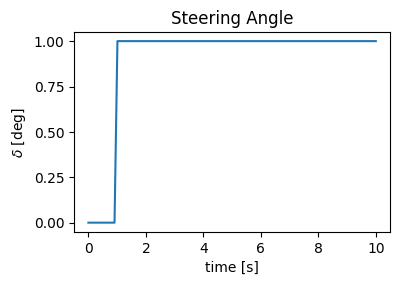

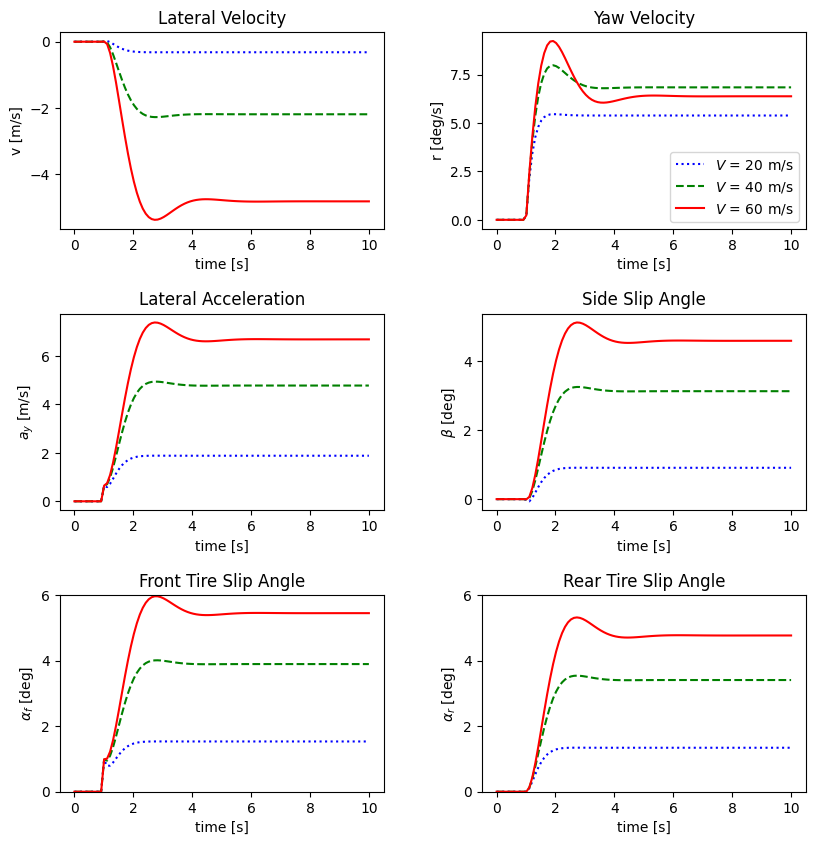

In [11]:
# Plot the solutions 
# ------------------
fig, ax = plt.subplots(1,1, figsize = (4.7,3.4))
plt.tight_layout(pad=4)
ax.plot(tsol, usol*180/(np.pi)) # [rad] -> [deg]
ax.set_xlabel('time [s]')
ax.set_ylabel('$\\delta$ [deg]')
ax.set_title('Steering Angle')

fig, ax = plt.subplots(3,2, figsize = (9,9))
plt.tight_layout(pad=4)

line_styles = [':', '--', '-']
colors = ['blue','green', 'red']
# ----------------------------------------------
# --------------- States -----------------------
#-----------------------------------------------
for i in range(len(V_labels)):
    ax[0,0].plot(tsol, xsol[0,:,i], linestyle = line_styles[i], color = colors[i])
ax[0,0].set_xlabel('time [s]')
ax[0,0].set_ylabel('v [m/s]')
ax[0,0].set_title('Lateral Velocity')

for i in range(len(V_labels)):
    ax[0,1].plot(tsol, xsol[1,:,i]*180/np.pi, linestyle = line_styles[i], color = colors[i], label = V_labels[i]) # [rad/s] -> [deg/s]
ax[0,1].set_xlabel('time [s]')
ax[0,1].set_ylabel('r [deg/s]')
ax[0,1].set_title('Yaw Velocity')
ax[0,1].legend()
# --------------------------------------------------
# ---------------- Outputs -------------------------
#---------------------------------------------------
for i in range(len(V_labels)):
    ax[1,0].plot(tsol, ysol[0,:,i], linestyle = line_styles[i], color = colors[i])
ax[1,0].set_xlabel('time [s]')
ax[1,0].set_ylabel('$a_y$ [m/s]')
ax[1,0].set_title('Lateral Acceleration')

for i in range(len(V_labels)):
    ax[1,1].plot(tsol, ysol[1,:,i]*180/np.pi, linestyle = line_styles[i], color = colors[i]) # [rad] -> deg
ax[1,1].set_xlabel('time [s]')
ax[1,1].set_ylabel('$\\beta$ [deg]')
ax[1,1].set_title('Side Slip Angle')

for i in range(len(V_labels)):
    ax[2,0].plot(tsol, ysol[2,:,i]*180/np.pi, linestyle = line_styles[i], color = colors[i]) # [rad] -> deg
ax[2,0].set_xlabel('time [s]')
ax[2,0].set_ylabel('$\\alpha_f$ [deg]')
ax[2,0].set_title('Front Tire Slip Angle')
ax[2,0].set_ylim([0,6])

for i in range(len(V_labels)):
    ax[2,1].plot(tsol, ysol[3,:,i]*180/np.pi, linestyle = line_styles[i], color = colors[i]) # [rad] -> deg
ax[2,1].set_xlabel('time [s]')
ax[2,1].set_ylabel('$\\alpha_r$ [deg]')
ax[2,1].set_title('Rear Tire Slip Angle')
ax[2,1].set_ylim([0,6])

mpl.rcParams['font.size'] = 12

### Note:
The results in this notebook were verified with the ones in [Pacejka, 2012].

### References
- Pacejka, H. (2012). Tire and vehicle dynamics. Elsevier.